In [1]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import Source.Particle as Particle
import Source.Parabolas as Parabolas
import Functions.Electric_fields as Electric_fields
import Functions.Qfactors as Qfactors

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 300

reload(Particle) # for debugging, can be removed
reload(Parabolas) # for debugging, can be removed
reload(Electric_fields) # for debugging, can be removed
reload(Qfactors); # for debugging, can be removed

The purpose of this tool is to calculate the orbit of different particles in a toroidal magnetic field $\vec B$ with large aspect ratio (LAR) and constant $g,I$. The orbits are calculated by solving Hamiltons equations as presented in "The theory of toroidally confined plasmas" by R. B. White,with a 4th order Runge-Kutta method

Our dynamical variables are  $\theta, P_\theta, \zeta, P_\zeta$ and $ \rho_{||}$, and they are governed through Hamilton's equations:

$$
\dot \theta = \dfrac{1}{D}\rho_{||}B^2 +\dfrac{g}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

$$
\dot \psi_p = \dfrac{\dot\psi}{q(\psi)} = -\dfrac{g}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta}\bigg]
$$

$$
\dot \rho_{||} = -\dfrac{1}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta} \bigg]
$$

$$
\dot \zeta = \dfrac{\rho_{||}B^2}{D} - \dfrac{I}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

where:  $\quad B = 1 - \sqrt{2\psi}\cos(\theta)$

We can then calculate the canonical momenta as $P_\theta = \psi + \rho_{||}I$ and $P_\zeta = \rho_{||} g -\psi_p$

### Part 1: Particle Initialization and obrit calculation

In this cell we can create multiple particles independently. By setting cwp (current working particle), we chose the particle to proceed. That way we can keep all previous particles in memory and switch cwp at any point.

In [2]:
# Set up ψ_(p,wall), E and B fields, and q factor 
psi_wall = 0.12 # Better be < .5
q = Qfactors.Hypergeometric(psi_wall)
B = [0, 1, 1000] # I, g, B0(Field strength on axis in [Gauss] = 10^(-4)[T])
Efield = Electric_fields.Radial(psi_wall, q)

# Create Particle
species = "e"
# Initial Conditions
mu = 10**(-5) # Magnetic moment
theta0 = 0
psi0 = 0.2*psi_wall # Better be < psi_wall
z0 = 0
Pz0 = -0.0125
tspan = np.linspace(0, 100000, 100000) # t0, tf, steps

init_cond = [theta0, psi0, z0, Pz0]

#Particle Creation
Electron1 = Particle.Particle(species, init_cond, mu, tspan, q, B, Efield, psi_wall)
cwp = Electron1
cwp.orbit()

Constants of motion:
	Particle Energy (normalized):	E = 3.287896e-05
	Particle Energy (keV):		E = 5.782817e+04 eV
	Toroidal Momenta:		Pζ = -0.0125

Other Quantities:
	Particle of Species:		"e"
	Orbit Type:			Passing - Confined
	Major Radius:			R = 1 meters
	Time unit:			ω = 1.758820e+10 Hz 
	Gyro radius: 			ρ = 5.734018e-05 cm 



### Part 2: Plots

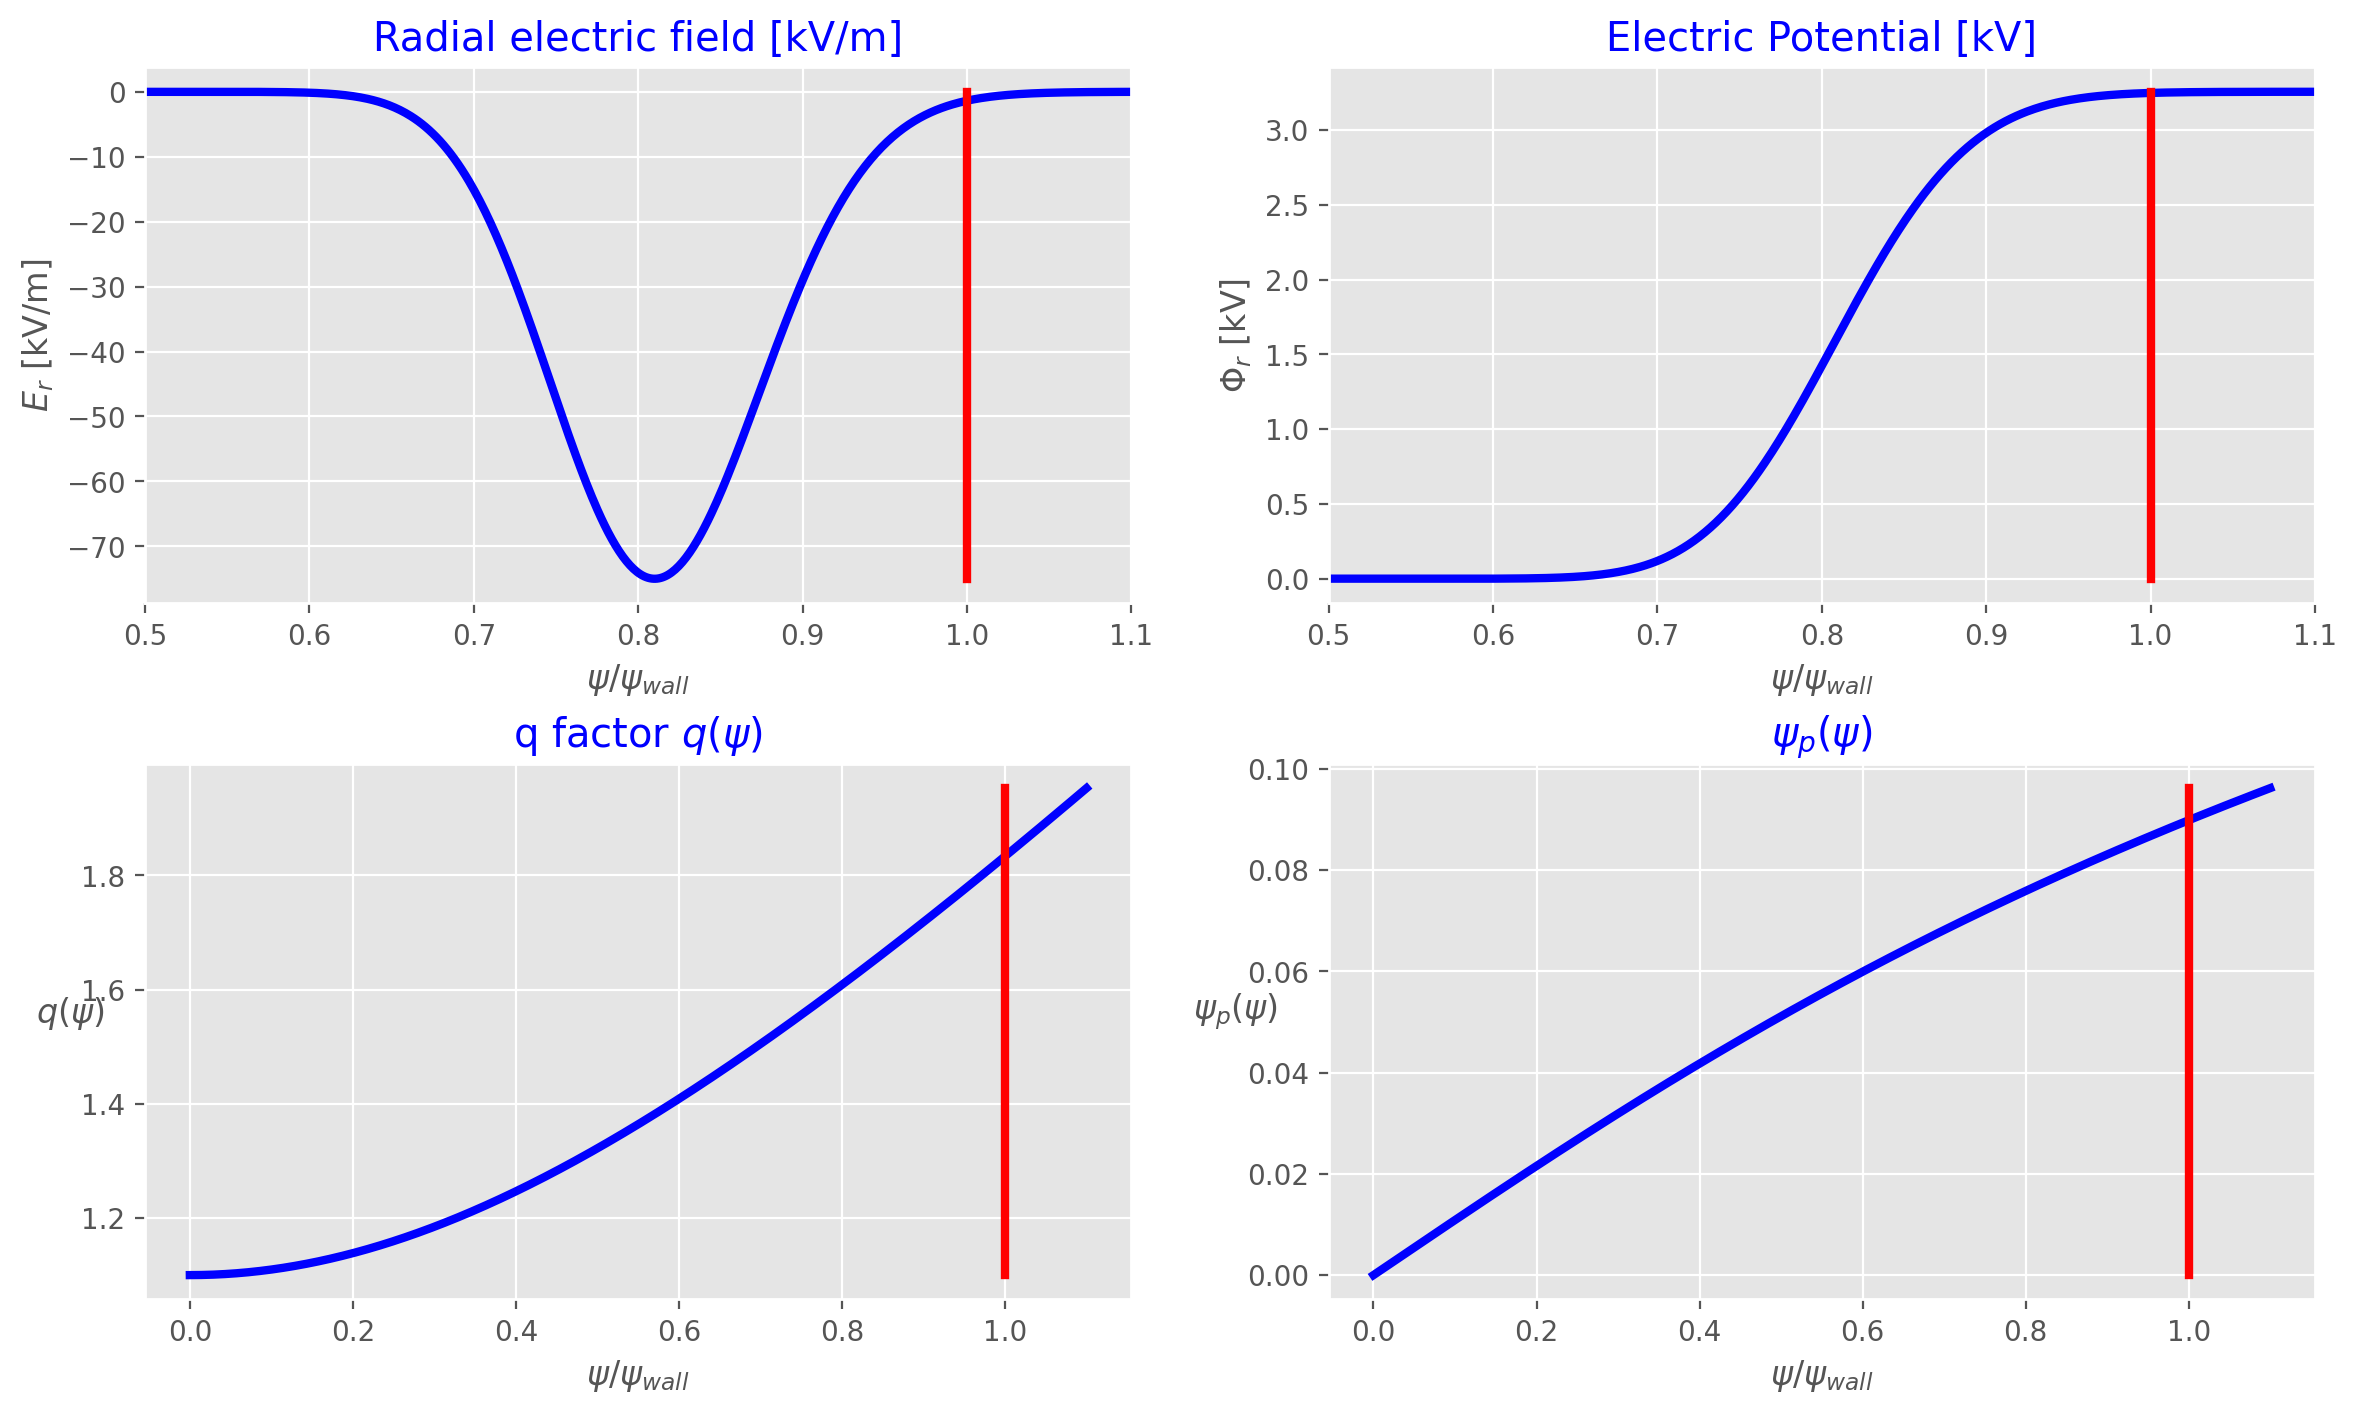

In [3]:
cwp.plot_electric(q_plot = True, zoom = [0.5, 1.1])

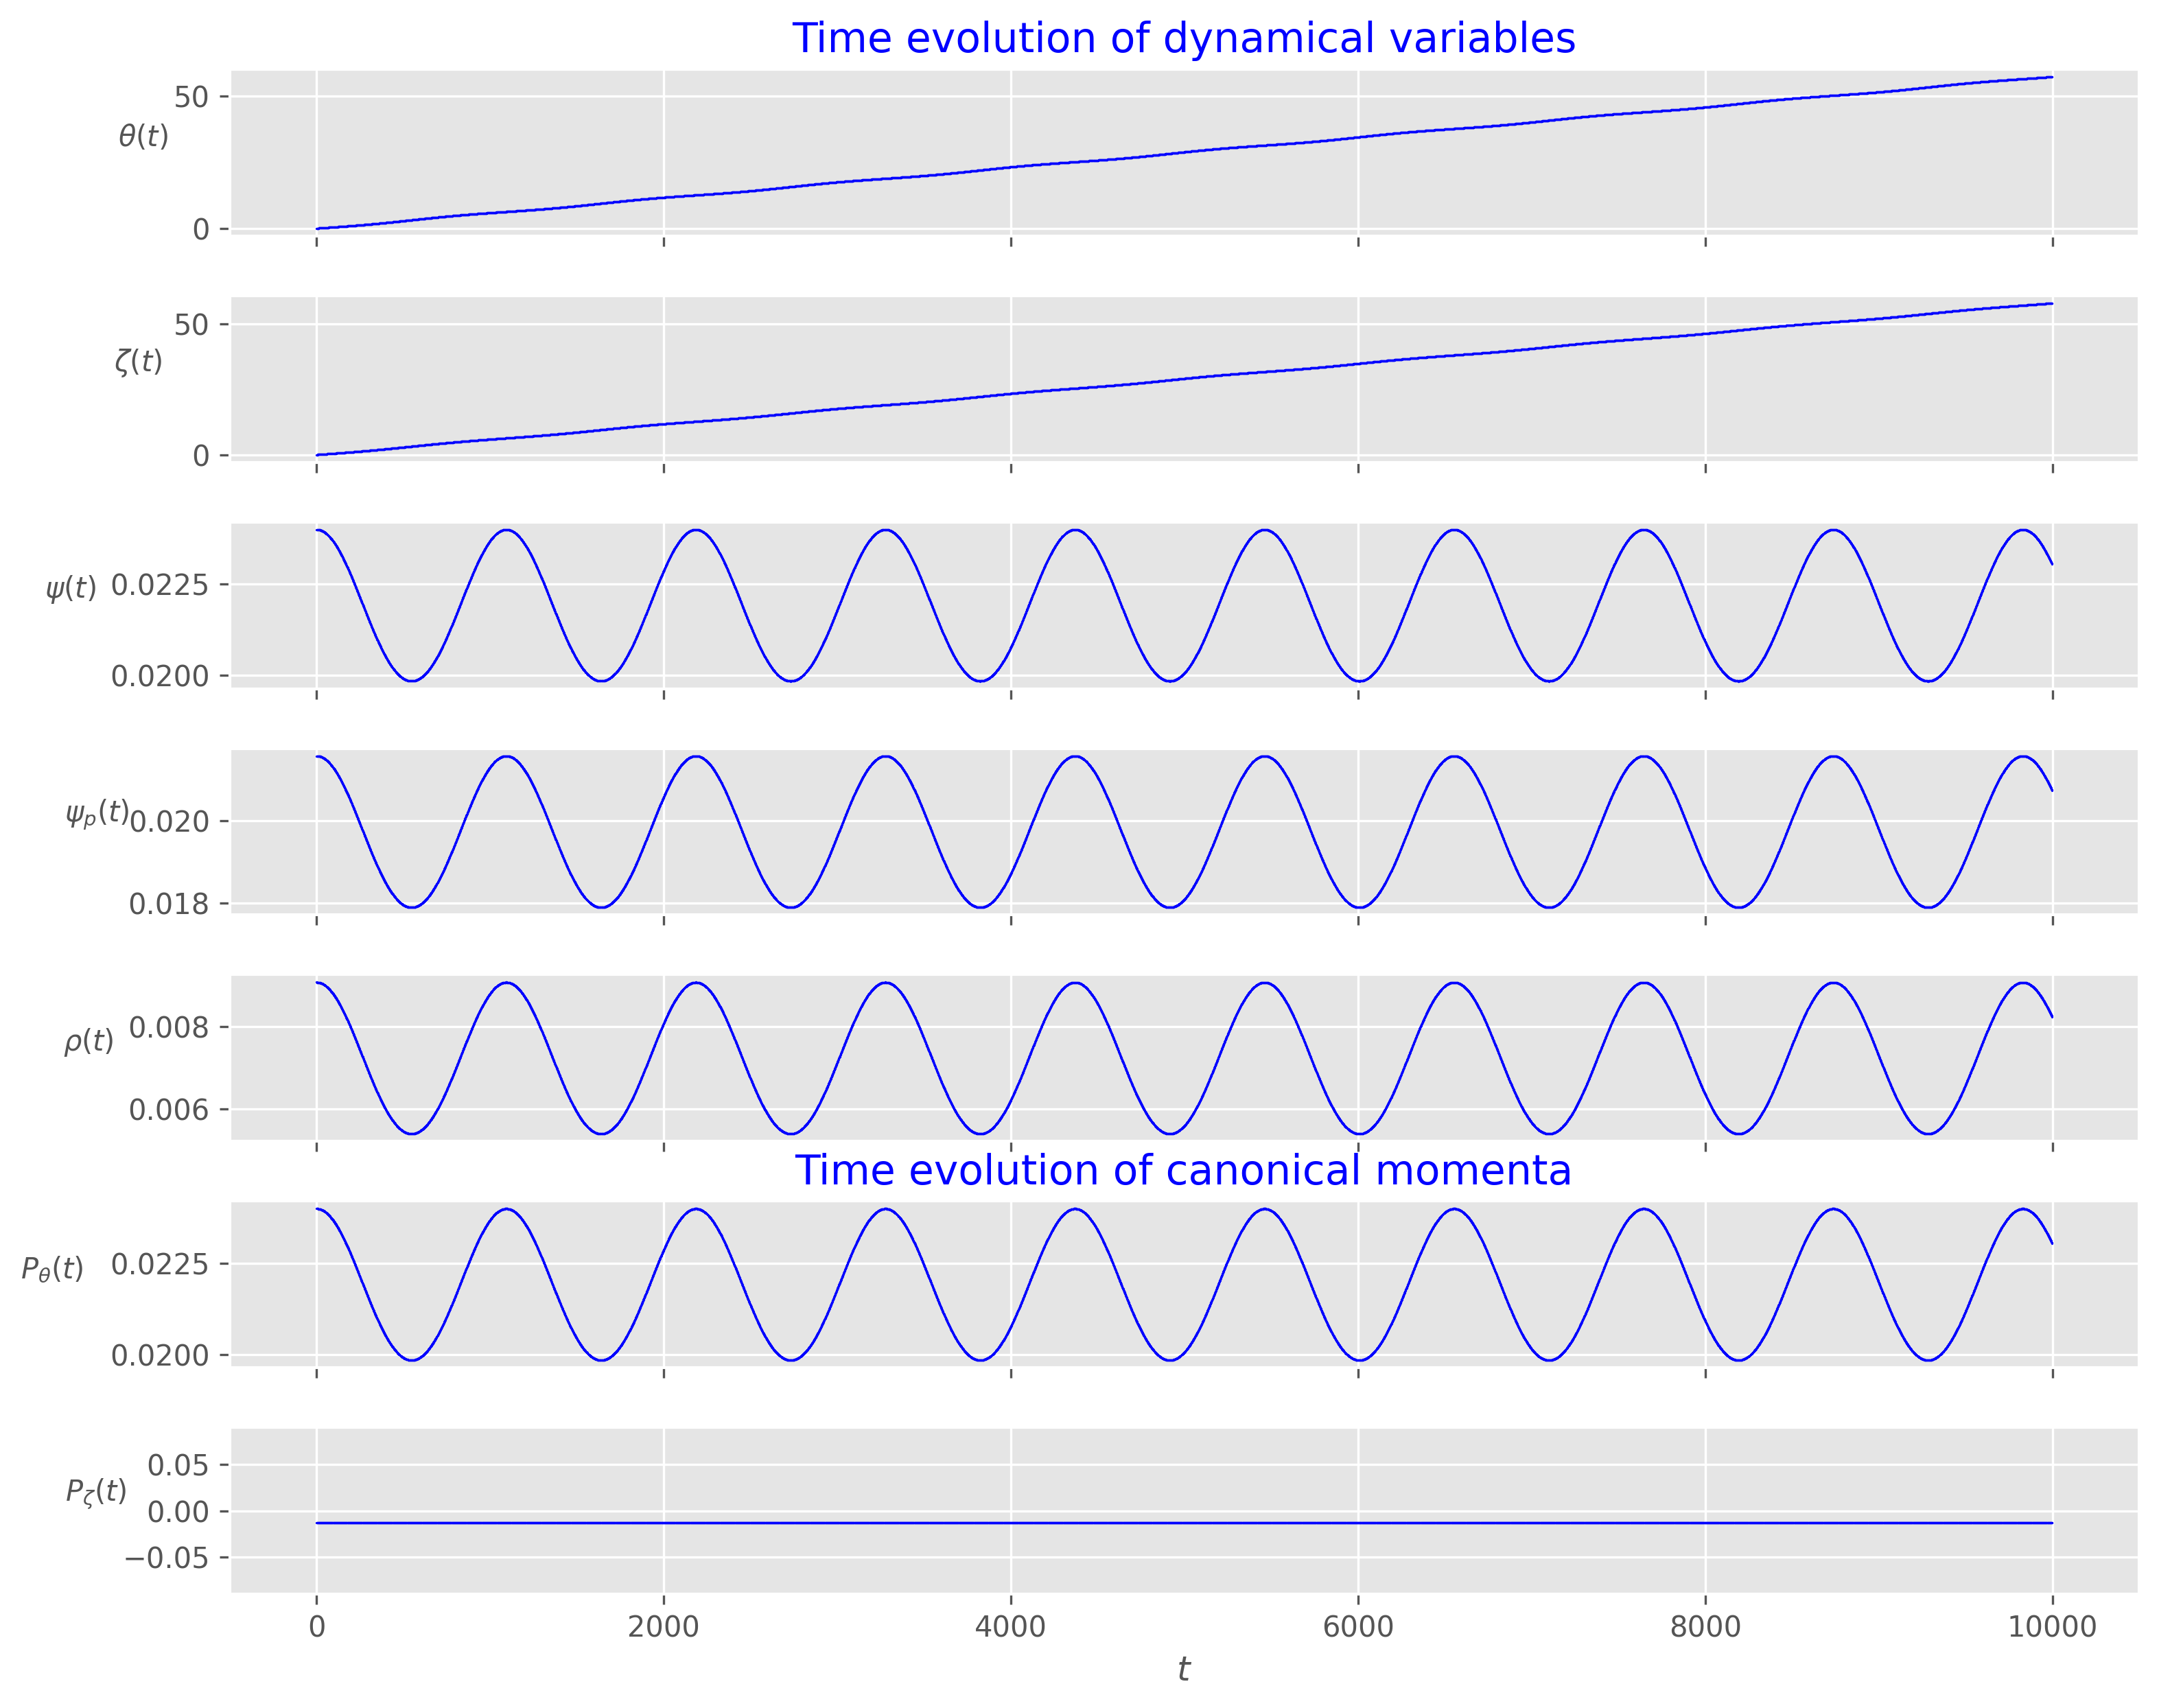

In [4]:
cwp.plot_time_evolution(percentage =10)

In [5]:
#cwp.plot_drift(theta_lim = [-np.pi ,np.pi])

### Energy Contour Plots

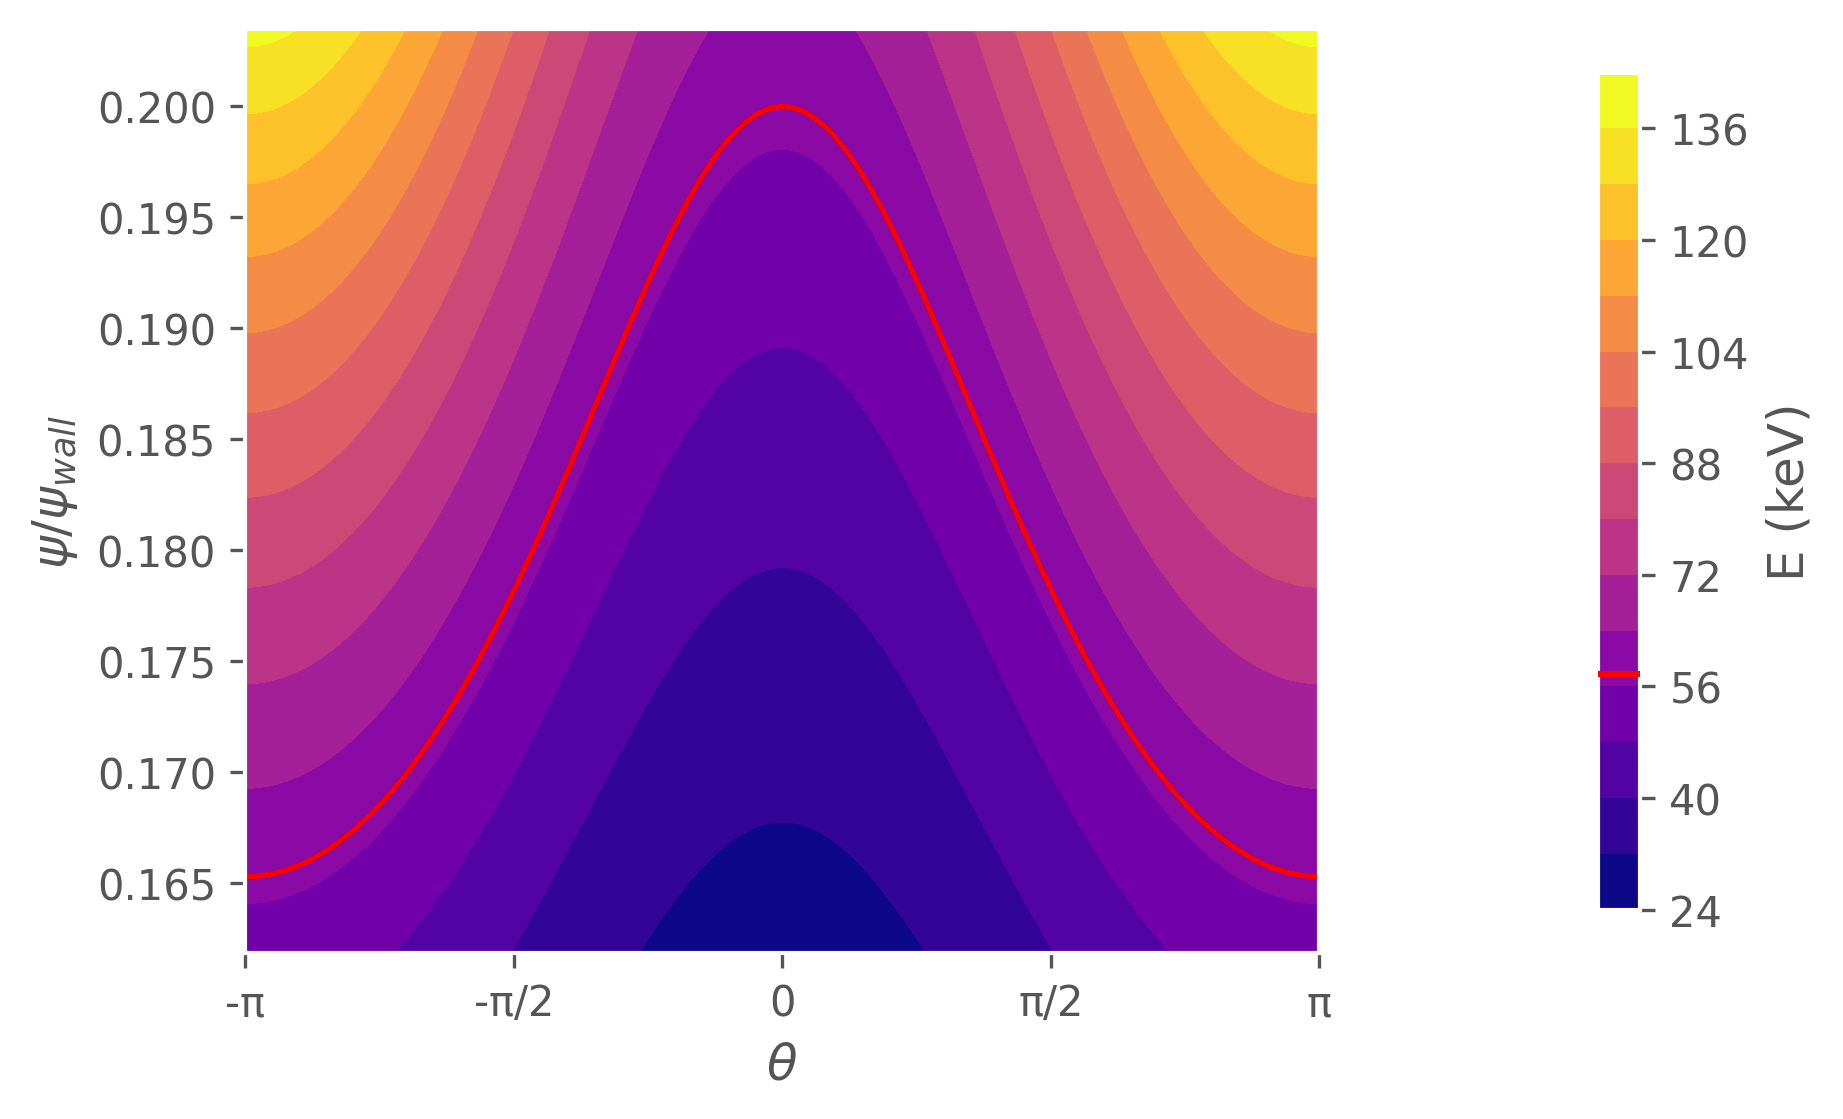

In [6]:
cwp.contour_energy(
    theta_lim = [-np.pi ,np.pi], psi_lim = "auto", 
    plot_drift=True, contour_Phi = True, units = "keV"
)

### Orbit types parabolas

The top left parabola is defined in White as:

$$
\dfrac{(P_\zeta + \psi_{wall})^2B^2_{min}}{2g^2(\psi_{wall})}+\mu B_{min}+\Phi_{min}-E=0
$$

We can re-order the terms as such:

$$
\bigg(\dfrac{\mu B_0}{E} \bigg) = - \dfrac{B_{min}B_0\psi^2_{wall}}{2g^2E}
\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)^2 - 
\dfrac{B_{min}B_0\psi^2_{wall}}{g^2E}\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)-
\dfrac{B_{min}B_0\psi^2_{wall}}{2g^2E} + \dfrac{B_0}{B_{min}}
\bigg(1-\dfrac{\Phi_{min}}{E}\bigg) 
$$

By defining the new variables:

$$
x=\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)\quad,\quad y = \bigg(\dfrac{\mu B_0}{E} \bigg)
$$

we define a parabola $y = \alpha x^2 + \beta x + \gamma$. Now we can easily find the minima/maxima and axis intercepts.\

Note: Since $B = 1 - \sqrt{2\psi}\cos\theta \quad$,   $\psi_{wall}$ should be less that 0.5

As for figuring out if the particle is Lost or Confined, we need only to check if its orbit point lies in-between the 2 left parabolas.

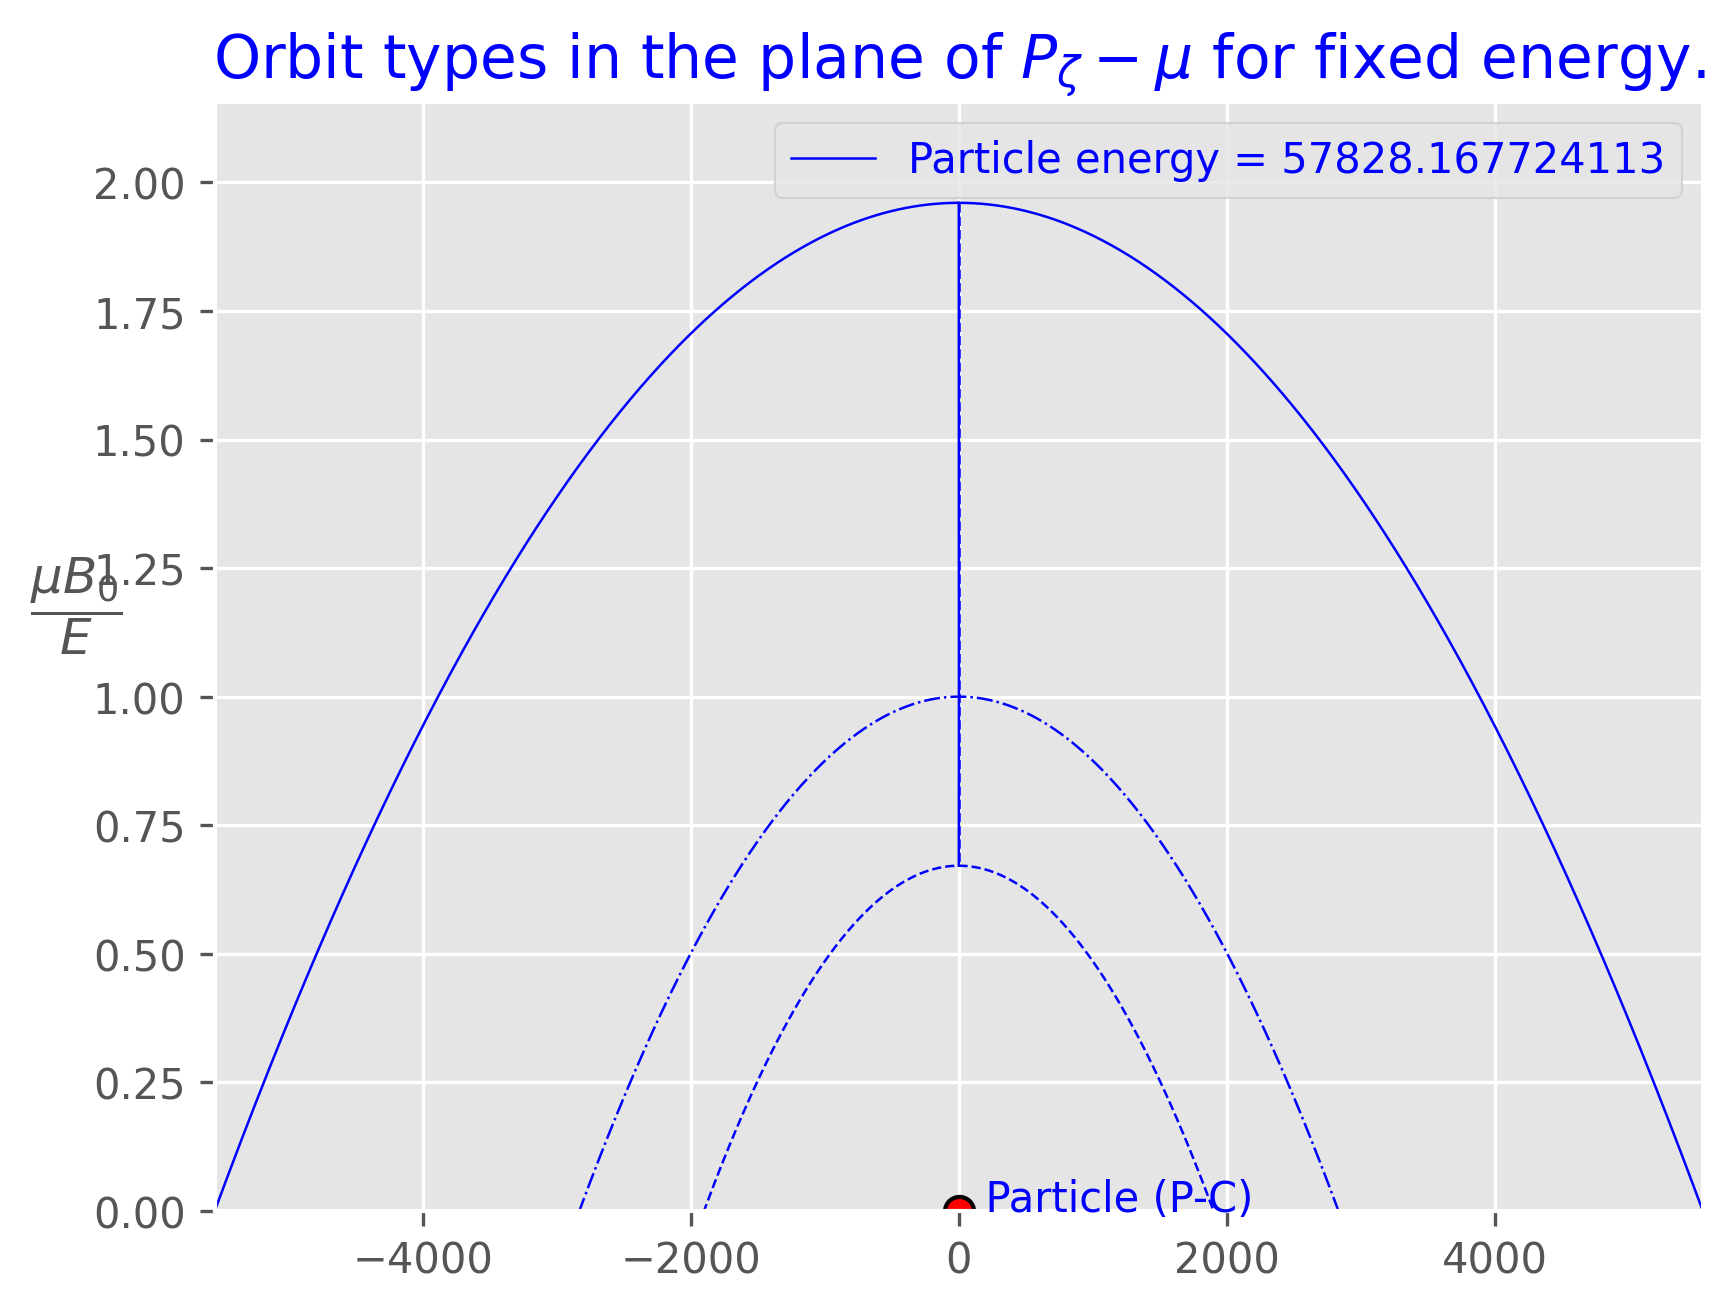

In [7]:
Parabolas_plot = Parabolas.Orbit_parabolas(cwp)
Parabolas_plot.plot_parabolas()
Parabolas_plot.plot_tp_boundary()
cwp.plot_orbit_type_point()
#λαθος

### Torus Poincare map and 3d Torus orbits

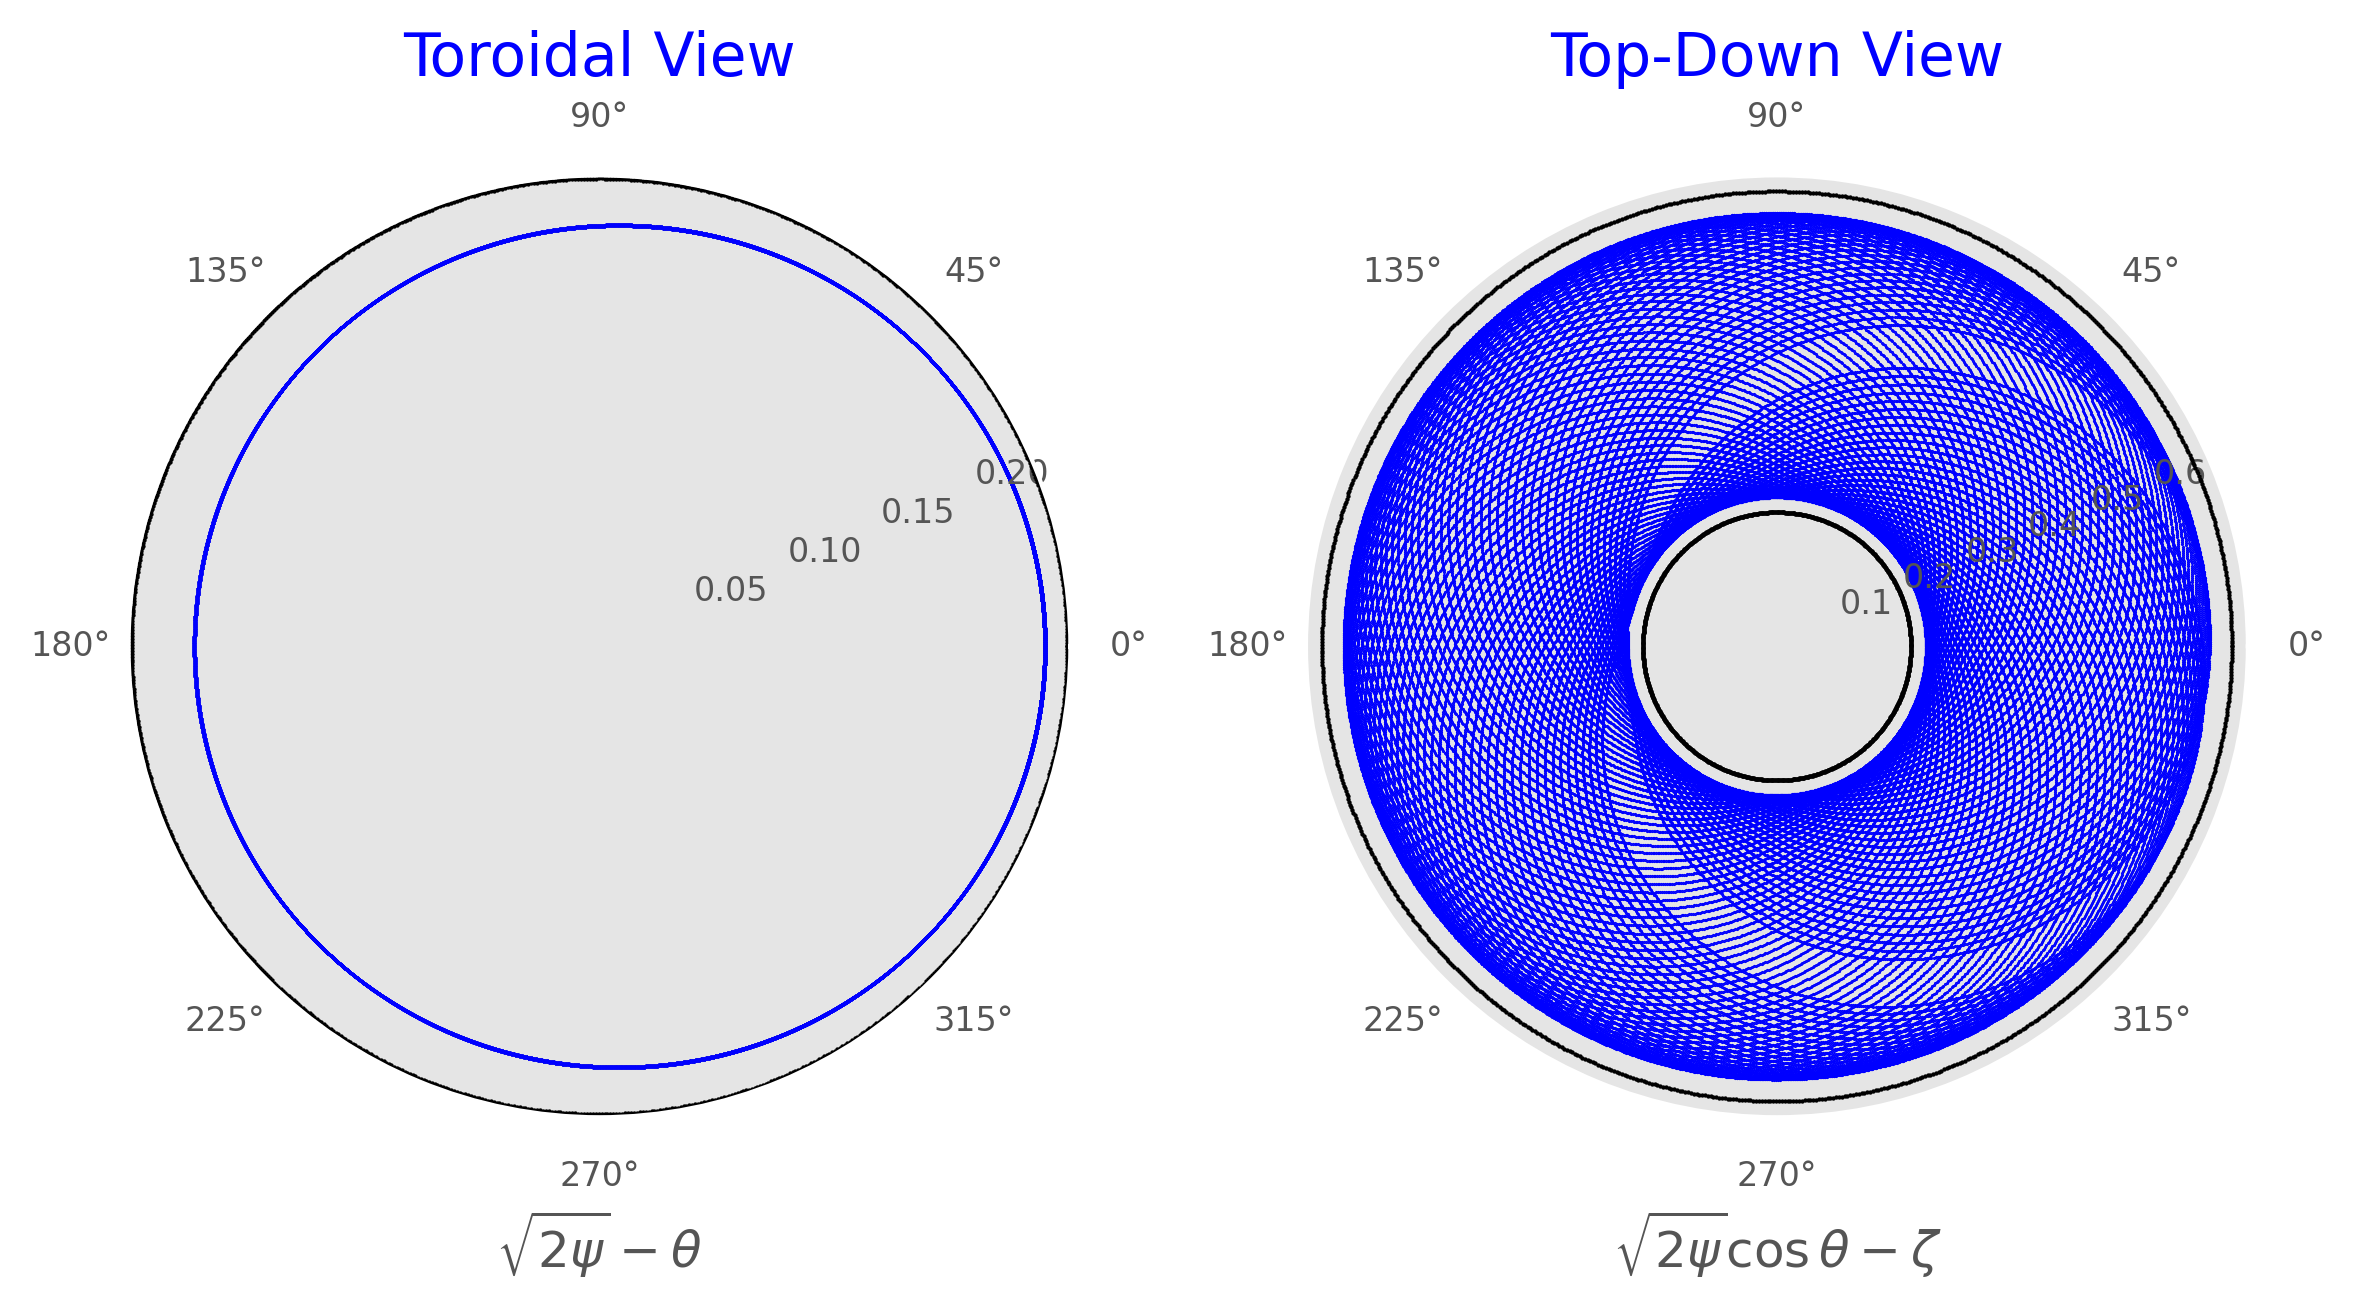

In [8]:
cwp.plot_torus2d(percentage = 100)

In [9]:
cwp.R

np.float64(0.41826978183934405)

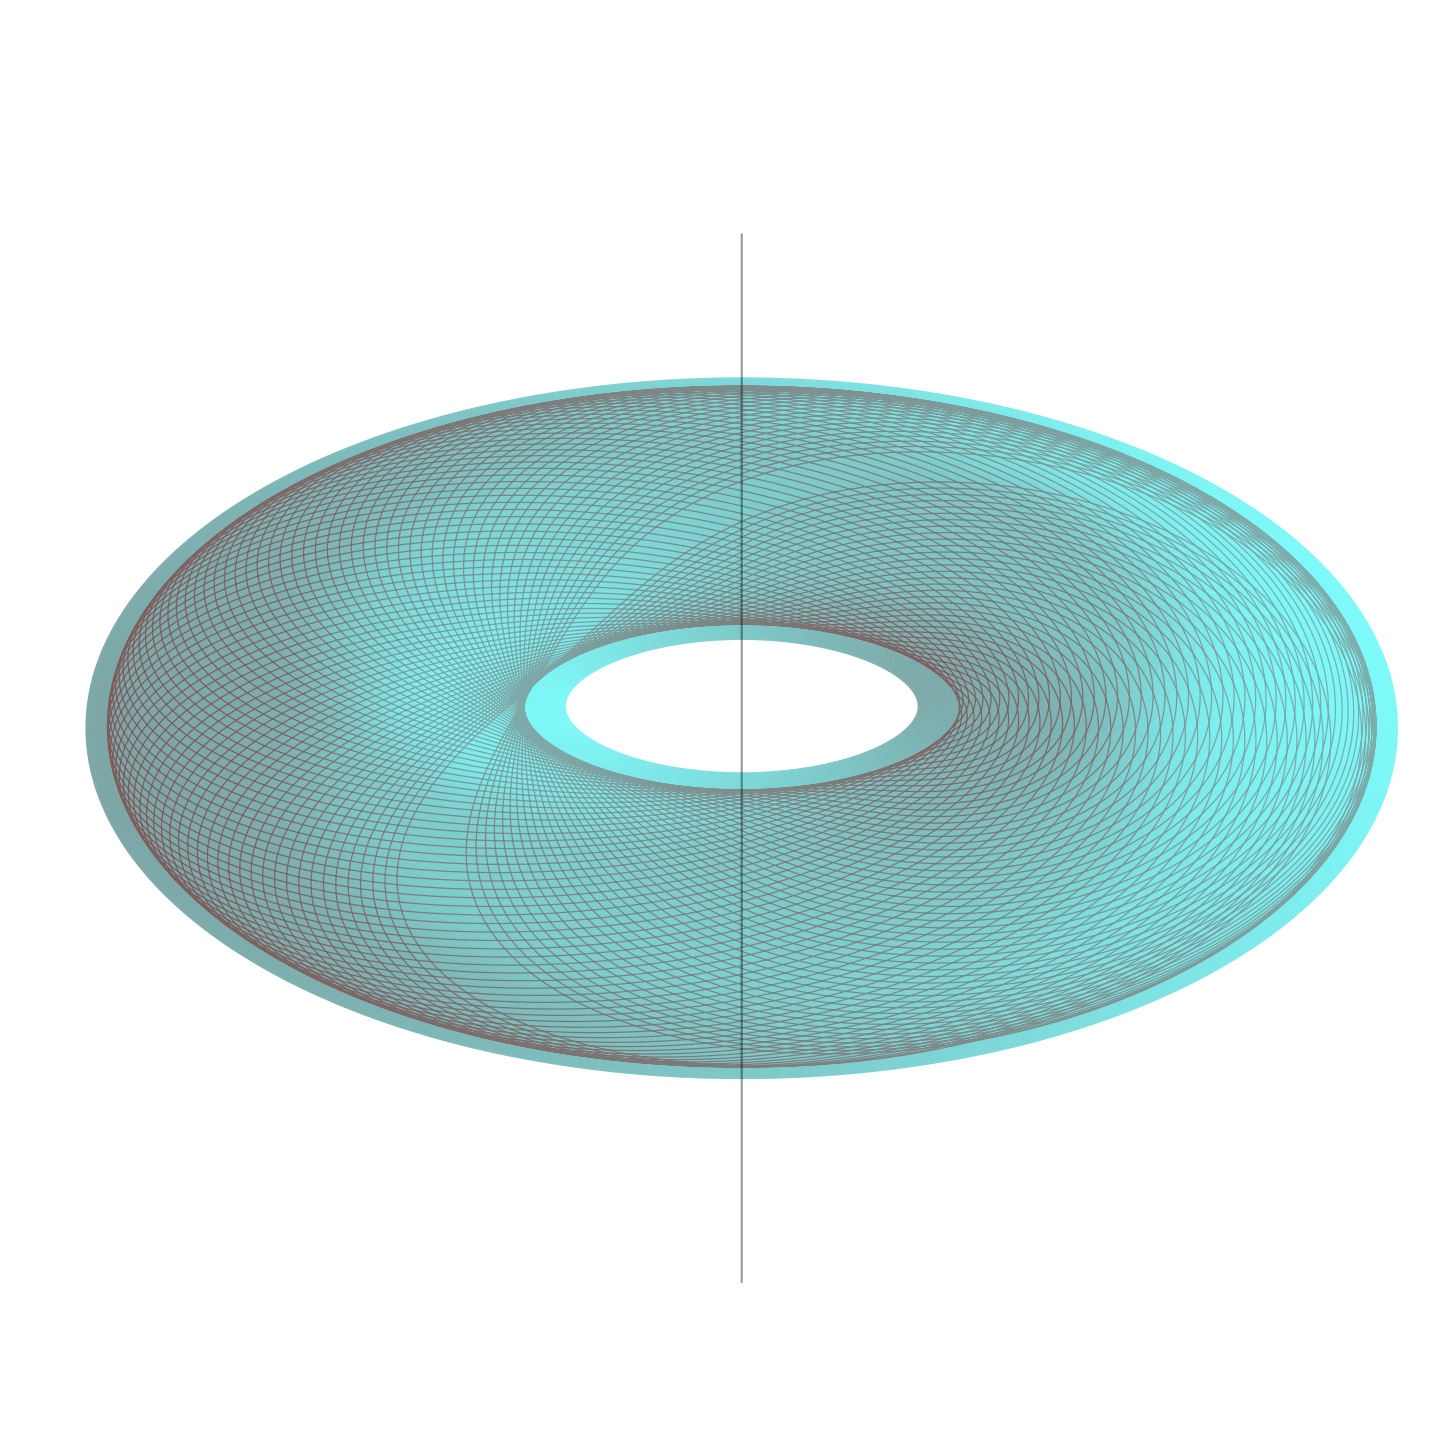

In [10]:
cwp.plot_torus3d(percentage = 100, hd = False, bold=False)